In [107]:
from langgraph.types import Command
from langgraph.graph import StateGraph,START,END

from typing import Literal,Annotated,TypedDict,Optional,List
from pydantic import BaseModel,Field

from langchain_community.document_loaders import WebBaseLoader
from langchain_core.prompts import ChatPromptTemplate
from langchain_tavily import TavilySearch

from langchain.tools import tool
from langgraph.graph import add_messages
from langgraph.prebuilt import ToolNode

import os
import dotenv

In [98]:
from langchain.chat_models import init_chat_model

dotenv.load_dotenv()
OPENAI_API = os.getenv("OPENAI_API_KEY")
TAVILY_API = os.getenv("TAVILY_API_KEY")

model = init_chat_model("gpt-4o",api_key = OPENAI_API,temperature=0)

### NEEDS USER INTERRUPTION, HUMAN IN THE MIDDLE, WHEN THE CHATBOT DECIDES TO QUIT THE CONVO. BUT THE USER DID NOT INTEND TO QUIT. ASK THE USER BEFORE QUITTING.

In [100]:
class ProductContext(BaseModel):
    product_model : str = Field(...,description = "The name and the version of the product.")
    product_size : Optional[str] = Field(...,description = "The size of the product if it exists.")
    product_color : Optional[str] = Field(...,description = "The color of the product if it exists.")
    product_price : str = Field(...,description = "The price of the product.")
    product_rating : str = Field(...,description = "The rating of the product")
    in_stock : Optional[bool] = Field(...,description = "The status of the product stock. Return 0 if it is out of stock or no mention, 1 if it is in stock.")

class ProductContext(BaseModel):
    product_info : List[ProductContext]
    
class UserIntention(BaseModel):
    wants_to_quit : Literal["quit","continue"] = Field(description="Decide if the user wants to quit the conversation")
    
class CustomState(TypedDict):
    messages : Annotated[list,add_messages]
    state_of_conversation : bool = True # True if the conversation is not interrupted and False otw.
    user_wants_to_quit : bool = False
    product_info: Optional[ProductContext]

In [101]:
@tool
def search_amazon(product_name:str): # At this point, we must have already received the relevant keyword. Now we query amazon with it
    """Extracts the product name mentioned in the user query and searches amazon marketplace for the extracted product name."""

    sys_template = """You are a helpful AI Assistant that extracts the product name from the user query.  
    If the product has a version name or number, it should be included in the output.
    For example, User query is 'How much is the iphone16 price? ', Your should answer should be iphone 16.    
    """
    
    AMZ_TEMPLATE = """
        You are given text which is extracted from a website.
        Here is the context : {context}
        Here is the product name : {product_name}
    """

    SYS_PROMPT = """
        The user asked you to search a product on the Amazon Marketplace.
        You are given a product and its features including its name,size,color,price,rating and boolean value if it is in stock.
        Prepare a final response for the user given the context. Make it classy and aside from the context, use 2 sentences max.
        Your preference should be to represent this in a bulletpoint fashion. 
        Here is the context : {context}
    """

    #last_message = state["messages"][-1].content
    #product_name = model.invoke([{"role":"system","content":sys_template},{"role":"user","content":last_message}])
    product_name = product_name.replace(" ","")
    url = f"https://amazon.com.tr/s?k={product_name}"
    
    loader = WebBaseLoader(url)
    amazon_response = loader.load()
    amazon_context = amazon_response[-1].page_content.replace("\n","") # there's usually a lot of new lines.#STR
    prompt = ChatPromptTemplate.from_template(AMZ_TEMPLATE)
    model_structured = model.with_structured_output(ProductContext)
    chain = prompt | model_structured

    chain_response = chain.invoke({"context":amazon_context,"product_name":product_name}) # Structured output
    context = chain_response.model_dump_json() # Json Context as a STR
    final_response = model.invoke([{"role":"system","content":SYS_PROMPT.format(context = context)}])
    return final_response.content
    
@tool
def search_web(user_query:str)->List[dict]:
    """ Searches the web for the user query with the TAVILY API."""
    tavily_search = TavilySearch(
    max_results=5,
    topic="general",
    api_key = TAVILY_API,
    search_depth="advanced"
    # include_answer=False,
    # include_raw_content=False,
    # include_images=False,
    # include_image_descriptions=False,  
    # time_range="day",
    # start_date=None,
    # end_date=None,
    # include_domains=None,
    # exclude_domains=None,
    # include_usage= False
)
    result = tavily_search.invoke({"query": user_query})
    return result["results"]

tool_list = [search_amazon,search_web]
tool_node = ToolNode(tools=tool_list)
model = model.bind_tools(tool_list)

In [102]:
def detect_end_of_conversation(state:CustomState)->Command[Literal["agent_node","middleware_node"]]:# either go back to the agent node or end the convo
    SYS_PROMPT = """ Detect the end of the conversation. Analyze user intentions. If the user wants to quit the conversation,
    he or she should not trigger the EOC by simply writing exit or quit. Look at the user mannerism and decide if the conversation
    should continue or end.
    """
    last_msg = state["messages"][-1].content # Get the last human message
    response = model.with_structured_output(UserIntention).invoke([{"role":"system","content":SYS_PROMPT},{"role":"user","content":last_msg}])
    final_response = response.wants_to_quit
    CONVO_STATE = True
    
    if final_response == "continue":
        next_node = "agent_node"
    else:
        next_node = "middleware_node"

    return Command(goto=next_node) #,update={"state_of_conversation":CONVO_STATE} # I believe that we do not need to update the messages. if I am wrong, use {"messages" : [response]}

def user_middleware(state:CustomState)->Command[Literal["agent_node",END]]:
    MW_PROMPT = """ Analyze the last user message and decide if the user actually wants to quit the conversation. 
    The user input you receive is the answer to the question 'Did you want to quit?'. So decide your answer based on this fact.
    """
    user_wants_to_quit = input("Did you want to quit the conversation? : ")
    final_response = model.with_structured_output(UserIntention).invoke([{"role":"system","content":MW_PROMPT},{"role":"user","content":user_wants_to_quit}])
    if final_response.wants_to_quit == "quit":
        next_node = END
        CONVO_STATE = False
    else:
        next_node = "agent_node"
        CONVO_STATE = True

    return Command(goto=next_node,update={"user_wants_to_quit": user_wants_to_quit,"state_of_conversation":CONVO_STATE})
    
def agent(state:CustomState)->Command[Literal["tool_node",END]]:
    messages = state["messages"] # Careful of the context window of the LLM if you intent to use it for a long time.
    response = model.invoke(messages)

    if response.tool_calls:
        next_node = "tool_node"
    else:
        next_node= END
    
    return Command(goto = next_node,update = {"messages": [response]})

In [103]:
graph = StateGraph(CustomState)
graph.add_node("detect_node",detect_end_of_conversation)
graph.add_node("agent_node",agent)
graph.add_node("middleware_node",user_middleware)
graph.add_node("tool_node",tool_node)
#graph.add_edge("agent_node","detect_node")
graph.add_edge(START,"detect_node")
graph.add_edge("agent_node",END)
graph.add_edge("tool_node","agent_node")
#graph.add_edge("detect_node","middleware_node")
app = graph.compile()

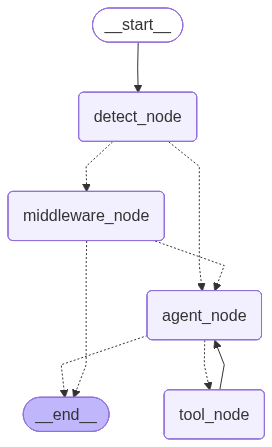

In [104]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [105]:
user_state = {"messages" : [],"state_of_conversation":True}
DEFAULT_SYS_PROMPT = """ You are a helpful AI Assistant. Have a conversation with the user. Be concise,precise and friendly to the user."""
user_state["messages"].append({"role":"system","content":DEFAULT_SYS_PROMPT})

while user_state["state_of_conversation"]: 
    user_input = input("Enter a message : ")
    user_state["messages"].append({"role":"user","content":user_input})
    
    response = app.invoke(user_state)
    #user_state["messages"].append({"role":"assistant","content":response})
    user_state["state_of_conversation"] = response["state_of_conversation"]
    if not response["state_of_conversation"]:
        print("Quitting the conversation. Bye.")
        break
    print(response["messages"][-1].content) # It used to quit and reprinted my message # AUTO QUIT was ON.

Enter a message :  what is happening in Venezuela?


Venezuela is currently experiencing significant political turmoil. Recently, U.S. military forces captured President Nicolás Maduro and his wife, Cilia Flores, following a large-scale attack. This has led to Vice President Delcy Rodriguez assuming the role of interim president. The situation has sparked mixed reactions among Venezuelans, with some expressing hope and others feeling anxious about the country's future.

The streets of Caracas have seen protests and visible signs of destruction due to recent airstrikes. The political landscape is uncertain, with opposition leader María Corina Machado calling for an opposition candidate to take power. Meanwhile, the international community, including countries like Russia and China, is reacting to the U.S.'s actions and its implications for Venezuela's oil resources.

The situation remains fluid, with ongoing concerns about governance, security, and the humanitarian crisis in the country.


Enter a message :  is there any news on Ekrem İmamoğlu?


### Current Events in Venezuela

Recent developments in Venezuela have been dramatic, with the U.S. conducting a military operation that resulted in the capture of Venezuelan President Nicolás Maduro and his wife, Cilia Flores. This has led to significant political upheaval, with Delcy Rodríguez being sworn in as interim president. The situation has created uncertainty about Venezuela's future, with mixed reactions from the international community and ongoing challenges for the Venezuelan people, including shortages of supplies and water. The U.S. and other countries are working to support a transition to democracy in Venezuela.

For more details, you can read the full articles on [Global R2P](https://www.globalr2p.org/publications/statement-on-the-recent-developments-in-venezuela/) and [Al Jazeera](https://www.aljazeera.com/where/venezuela/).

### News on Ekrem İmamoğlu

Ekrem İmamoğlu, the mayor of Istanbul and a prominent opposition figure in Turkey, has been arrested, sparking wide

Enter a message :  okey ty for your support. end the convo
Did you want to quit the conversation? :  yes


Quitting the conversation. Bye.


### IMPROVEMENT IDEA : Add the links of the products/news if the user wants to have a look.